In [1]:
import os
import imutils
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
images_folder = "../img"

# First site Scripts

### Global functions

In [3]:
def apply_3images(func, flags):
    
    images = ["cat.jpg", "white_volvo.jpg", "quokka.jpg"]

    for img in images:
        im = cv.imread(os.path.join(images_folder, img), flags['channels'])
        func(im.copy(), flags)

### Fourier Transform using numpy

In [4]:

def fft_numpy(img, flags):
    
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    magnitude_spectrum = 20 * np.log(np.abs(fshift))

    plt.figure(figsize=(10, 8))
    plt.subplot(121), plt.imshow(img, cmap = 'gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(magnitude_spectrum, cmap = 'gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()

In [5]:
def HPF_numpy(im, flags):
    
    f = np.fft.fft2(im)
    fshift = np.fft.fftshift(f)
    
    rows, cols = im.shape
    crow,ccol = rows//2 , cols//2
    fshift[crow-30:crow+31, ccol-30:ccol+31] = 0

    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.real(img_back)

    plt.figure(figsize=(12, 10))

    plt.subplot(131),plt.imshow(im, cmap = 'gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(132),plt.imshow(img_back, cmap='gray')
    plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])

    plt.subplot(133),plt.imshow(img_back)
    plt.title('Result in JET'), plt.xticks([]), plt.yticks([])
    plt.show()

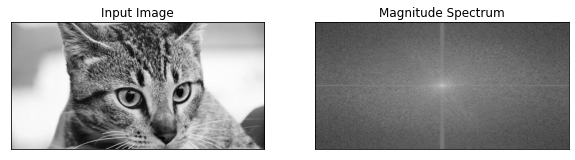

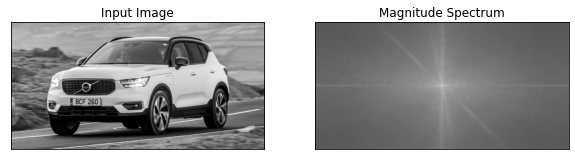

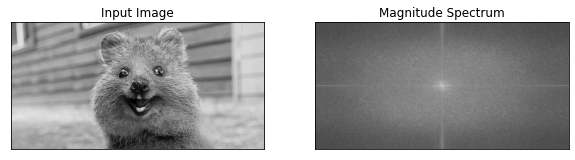

In [6]:
apply_3images(fft_numpy, {'channels':0})

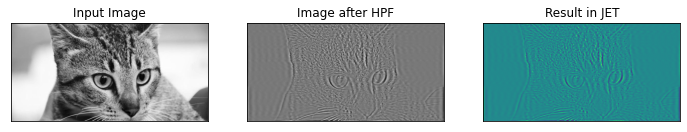

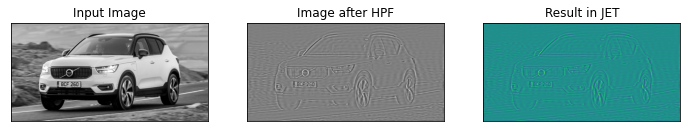

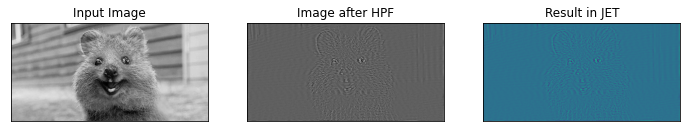

In [7]:
apply_3images(HPF_numpy, {'channels':0})

### Fourier Transform using opencv

In [8]:
def fft_opencv(img, flags):
    
    dft = cv.dft(np.float32(img), flags = cv.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20*np.log(cv.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

    plt.figure(figsize=(12, 8))

    plt.subplot(121),plt.imshow(img, cmap = 'gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()

In [9]:
def blur_fft(img, flags):
    
    dft = cv.dft(np.float32(img), flags = cv.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    rows, cols = img.shape
    crow,ccol = rows//2 , cols//2

    mask = np.zeros((rows,cols,2),np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1

    fshift = dft_shift*mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv.idft(f_ishift)
    img_back = cv.magnitude(img_back[:,:,0],img_back[:,:,1])

    plt.figure(figsize=(12, 8))

    plt.subplot(121),plt.imshow(img, cmap = 'gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()

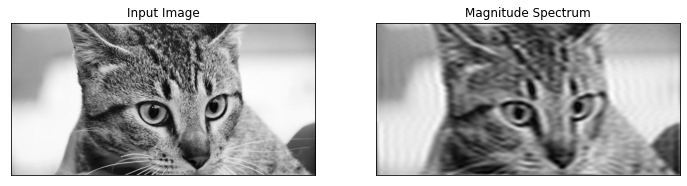

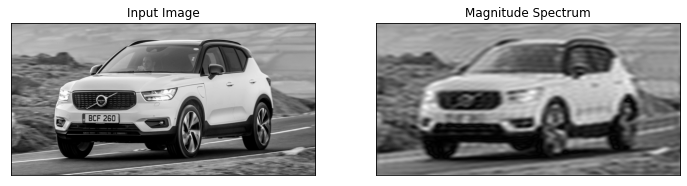

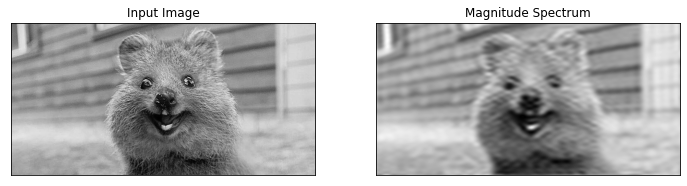

In [10]:
apply_3images(blur_fft, {'channels':0})

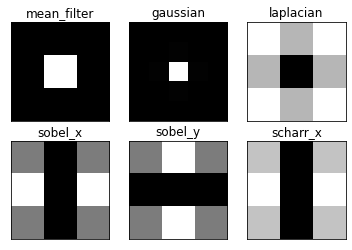

In [21]:
# simple averaging filter without scaling parameter
mean_filter = np.ones((3,3))
# creating a gaussian filter
x = cv.getGaussianKernel(5,10)
gaussian = x*x.T
# different edge detecting filters
# scharr in x-direction
scharr = np.array([[-3, 0, 3],
                   [-10,0,10],
                   [-3, 0, 3]])
# sobel in x direction
sobel_x= np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
# sobel in y direction
sobel_y= np.array([[-1,-2,-1],
                   [0, 0, 0],
                   [1, 2, 1]])
# laplacian
laplacian=np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])
filters = [mean_filter, gaussian, laplacian, sobel_x, sobel_y, scharr]
filter_name = ['mean_filter', 'gaussian','laplacian', 'sobel_x', \
                'sobel_y', 'scharr_x']
fft_filters = [np.fft.fft2(x) for x in filters]
fft_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)+1) for z in fft_shift]
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(mag_spectrum[i],cmap = 'gray')
    plt.title(filter_name[i]), plt.xticks([]), plt.yticks([])
plt.show()

# Second site Scripts

In [12]:
def detect_blur_fft(image, flags):
    
    size, vis, thresh = flags['size'], flags['vis'], flags['thresh']
    
    (h, w) = image.shape
    (cX, cY) = (int(w // 2.0), int(h // 2.0))
    
    fft = np.fft.fft2(image)
    fftShift = np.fft.fftshift(fft)
    
    # check to see if we are visualizing our output
    if vis:
        # compute the magnitude spectrum of the transform
        magnitude = 20 * np.log(np.abs(fftShift))
        # display the original input image
        (fig, ax) = plt.subplots(1, 2)
        ax[0].imshow(image, cmap="gray")
        ax[0].set_title("Input")
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        # display the magnitude image
        ax[1].imshow(magnitude, cmap="gray")
        ax[1].set_title("Magnitude Spectrum")
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        # show our plots
        plt.show()
        
    fftShift[cY - size:cY + size, cX - size:cX + size] = 0
    fftShift = np.fft.ifftshift(fftShift)
    recon = np.fft.ifft2(fftShift)

    magnitude = 20 * np.log(np.abs(recon))
    mean = np.mean(magnitude)
    return (mean, mean <= thresh)

In [19]:
def blur_detector(orig, flags):

    orig = imutils.resize(orig, width=500)
    gray = cv.cvtColor(orig, cv.COLOR_BGR2GRAY)
    (mean, blurry) = detect_blur_fft(gray, flags)

    image = np.dstack([gray] * 3)
    color = (0, 0, 255) if blurry else (0, 255, 0)
    text = "Blurry ({:.4f})" if blurry else "Not Blurry ({:.4f})"
    text = text.format(mean)
    cv.putText(image, text, (10, 25), cv.FONT_HERSHEY_SIMPLEX, 0.7,
        color, 2)
    print("[INFO] {}".format(text))
    plt.imshow(image)
    plt.title("Output")
    plt.show()
    #cv.waitKey(0)
    
    if flags["test"] > 0:
        for radius in range(1, 6, 2):
            image = gray.copy()
            if radius > 0:
                image = cv.GaussianBlur(image, (radius, radius), 0)
                (mean, blurry) = detect_blur_fft(image, flags)
                image = np.dstack([image] * 3)
                color = (0, 0, 255) if blurry else (0, 255, 0)
                text = "Blurry ({:.4f})" if blurry else "Not Blurry ({:.4f})"
                text = text.format(mean)
                cv.putText(image, text, (10, 25), cv.FONT_HERSHEY_SIMPLEX,
                    0.7, color, 2)
                print("[INFO] Kernel: {}, Result: {}".format(radius, text))
            plt.imshow(image)
            plt.title("Test image")
            plt.show()
            #cv.waitKey(0)

[INFO] Not Blurry (24.6620)


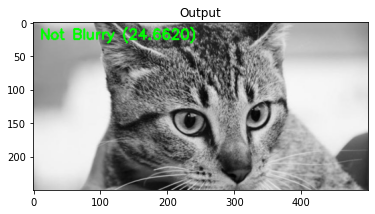

[INFO] Kernel: 1, Result: Not Blurry (24.6620)


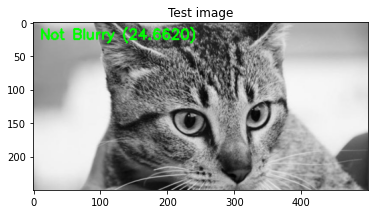

[INFO] Kernel: 3, Result: Not Blurry (16.6040)


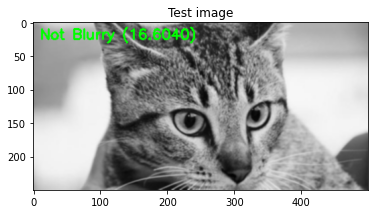

[INFO] Kernel: 5, Result: Not Blurry (11.5026)


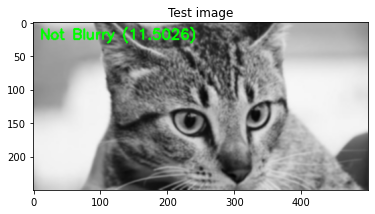

[INFO] Not Blurry (26.7145)


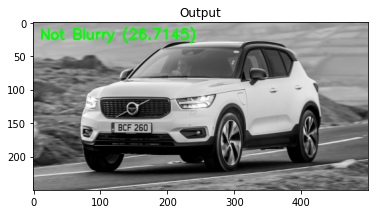

[INFO] Kernel: 1, Result: Not Blurry (26.7145)


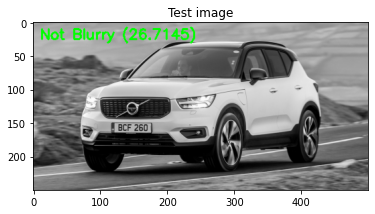

[INFO] Kernel: 3, Result: Not Blurry (15.2708)


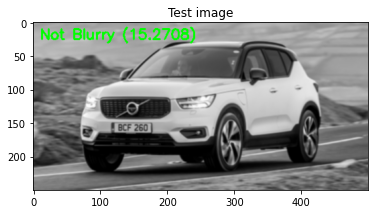

[INFO] Kernel: 5, Result: Blurry (7.1747)


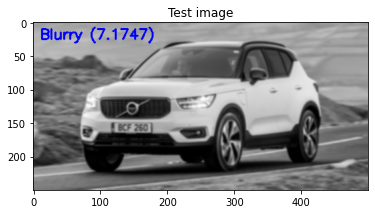

[INFO] Not Blurry (18.4658)


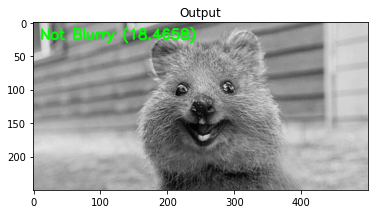

[INFO] Kernel: 1, Result: Not Blurry (18.4658)


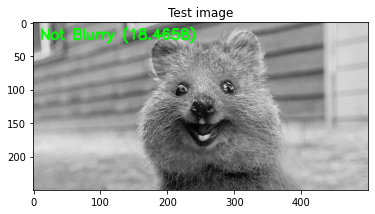

[INFO] Kernel: 3, Result: Blurry (5.6451)


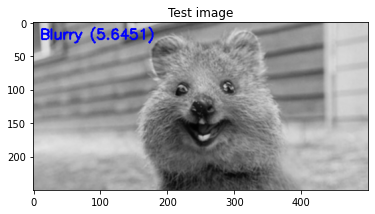

[INFO] Kernel: 5, Result: Blurry (-0.7783)


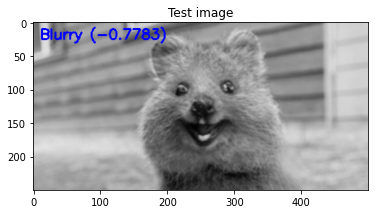

In [20]:
flags = {"size":60, "thresh":10, "vis":False, "channels":3, "test":1}
apply_3images(blur_detector, flags)